### Установка и импорт всех необходимых зависимостей

In [1]:
!pip install -q razdel
!pip install -q pymorphy2
!pip install -q git+https://github.com/ahmados/rusynonyms.git
!pip install -q natasha
!pip install -q pyaml-env
!pip install -q captum

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
scikit-image 0.21.0 requires networkx>=2.8, but you have networkx 2.6.3 which is incompatible.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.1 which is incompatible.


In [4]:
import os
import sys

path_to_alti = '/kaggle/input/transformer-contributions1/transformer-contributions'
if not path_to_alti in sys.path:
    sys.path.append(path_to_alti)

from src.utils_contributions import *
from src.contributions import ModelWrapper, ClassificationModelWrapperCaptum, interpret_sentence, occlusion

In [3]:
import xml.etree.ElementTree as ET
import pandas as pd
pd.set_option('display.max_columns', None)

import nltk
from nltk.corpus import stopwords
import re
import pymorphy2
import razdel
import string
from natasha import (
    MorphVocab,
    NewsMorphTagger,
    NewsEmbedding,
    Segmenter,
    NewsSyntaxParser,
    Doc
)

import torch
import tensorflow_hub as hub
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, AutoConfig
import numpy as np
from sklearn.metrics import f1_score

from tqdm import tqdm
from typing import *
from collections import defaultdict
from functools import partial
from scipy.special import logit

from lime.lime_text import LimeTextExplainer
import shap

nltk.download('stopwords')
nltk.download('punkt')
rus_stopwords = stopwords.words('russian')
punctuation = list(string.punctuation)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Работа с данными (kaggle)

In [5]:
datasets_folder = '/kaggle/input/sw-datasets/Russian-Sentiment-Analysis-Evaluation-Datasets'
datasets = ['SentiRuEval-2015-telecoms', 'SentiRuEval-2015-banks', 'SentiRuEval-2016-banks', 'SentiRuEval-2016-telecoms']
samples = ['test.xml', 'train.xml', 'test_etalon.xml']

In [8]:
def extract_data(path: str) -> pd.DataFrame:
    """
    функция для извлечения данных из xml
    """
    tree = ET.parse(path)
    root = tree.getroot()
    DataFrame = dict()
    database = root.findall('database')[0]
    DataFrame_columns = list()

    for idx, table in enumerate(database.findall('table')):
        for column in table.findall('column'):
            DataFrame[column.attrib['name']] = list()
            DataFrame_columns.append(column.attrib['name'])
        if idx == 0:
            break

    for table in database.findall('table'):
        for column in table.findall('column'):
            DataFrame[column.attrib['name']].append(column.text)

    data = pd.DataFrame(DataFrame, columns=DataFrame_columns)
    return data

# инициализация всех путей (kaggle)
banks_dataset = datasets[2]
path2samples = os.path.join(datasets_folder, banks_dataset)
banks = ['sberbank', 'vtb', 'gazprom', 'alfabank', 'bankmoskvy', 'raiffeisen', 'uralsib', 'rshb']

path2test = os.path.join(path2samples, samples[2])
data_test = extract_data(path2test)

path2train = os.path.join(path2samples, samples[1])
data_train = extract_data(path2train)

In [22]:
def extract_text_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    функция для первичной обработки текста от лишних символов
    """
    extracted_data = dict()
    extracted_data['text'] = list()
    extracted_data['0class'] = list()
    extracted_data['1class'] = list()

    for idx in range(len(data)):
        row = data.iloc[idx, :]
        banks_review = row[banks]
        unique_labels = set(banks_review)
        unique_labels.remove('NULL')

        # убираем все ненужные знаки
        filtered_text = re.sub('http[A-z|:|.|/|0-9]*', '', row['text'])
        filtered_text = re.sub('@\S*', '', filtered_text)
        filtered_text = re.sub('#|:|»|«|-|xD|;D|\"|_|/', '', filtered_text)
        filtered_text = re.sub(r'\.(?=\s)|,|(?<!\s)\.(?!\s)', ' ', filtered_text)
        filtered_text = re.sub(r'[A-Z]|[a-z]', '', filtered_text)
        filtered_text = re.sub(r'\d+', 'число', filtered_text)
        # надо немного подправить
        filtered_text = re.sub(r'\b(\w+)\s+\1\b', r'\1', filtered_text)
        filtered_text = re.sub(r'\s+', ' ', filtered_text).strip()
        new_text = filtered_text

        # сохраняем только уникальные токены (без придатка xml NULL)
        unique_labels = list(unique_labels)
        while len(unique_labels) < 2:
            unique_labels.append(unique_labels[-1])
        extracted_data['text'].append(new_text)
        for idx, label in enumerate(unique_labels):
            text_label = int(label) + 1
            extracted_data[f'{idx}' + 'class'].append(text_label)

    extracted_data = pd.DataFrame(extracted_data)
    
    # возвращаем dataframe
    return extracted_data

extracted_val = extract_text_features(data_test)
extracted_train = extract_text_features(data_train)

In [23]:
# пример твита из датасета
extracted_val.iloc[3308].text

'Цены на нефть попрежнему остаются на очень низких уровнях РБК НПЗ стремятся отложить импортные…'

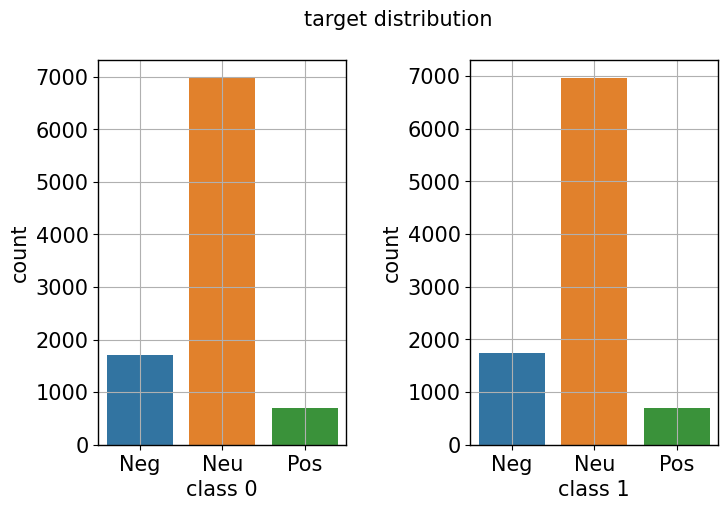

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# анализ распределения таргетов на твитах
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
plt.subplots_adjust(hspace=0.3, wspace=0.5)
fontsize=15

sns.countplot(data=extracted_train, x='0class', ax=axes[0])
axes[0].set_xlabel('class 0', fontsize=fontsize)
axes[0].set_ylabel('count', fontsize=fontsize)
axes[0].set_xticks([0, 1, 2], ['Neg', 'Neu', 'Pos'], fontsize=fontsize)
axes[0].grid(True)

sns.countplot(data=extracted_train, x='1class', ax=axes[1])
axes[1].set_xlabel('class 1', fontsize=fontsize)
axes[1].set_ylabel('count', fontsize=fontsize)
axes[1].set_xticks([0, 1, 2], ['Neg', 'Neu', 'Pos'], fontsize=fontsize)
axes[1].grid(True)

fig.suptitle('target distribution', fontsize=fontsize)

None

### Инициализируем модель (fine-tune) для решения нашей задачи классификации

In [25]:
fn_model_name = "DeepPavlov/distilrubert-base-cased-conversational"

class BERTmy(torch.nn.Module):
    def __init__(
        self, model_name: str, n_classes: int, 
        use_tok_type_ids: bool, p: float=0.05
    ) -> None:
        super(BERTmy, self).__init__()
        self.rubert = transformers.AutoModel.from_pretrained(
            model_name
        )
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(
            model_name, 
            do_lower_case=True,
            add_additional_tokens=True
        )
        self.use_tok_type_ids = use_tok_type_ids
        
        hidden_size_output = self.rubert.config.hidden_size
        self.pre_classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden_size_output, hidden_size_output, bias=True),
            torch.nn.Dropout(p),
            torch.nn.ReLU()
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden_size_output, hidden_size_output, bias=True),
            torch.nn.Dropout(p),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size_output, n_classes),
        )

    def forward(
        self, input_ids: torch.Tensor, attention_mask: torch.Tensor, 
        token_type_ids: torch.Tensor=None, output_attentions: bool=False,
        output_hidden_states: bool=False, return_dict: bool=True
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        
        input_dict = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'return_dict': True,
            'output_attentions': True,
            'output_hidden_states': True
        }
        if self.use_tok_type_ids and not token_type_ids is None:
            input_dict['token_type_ids'] = token_type_ids
        
        rubert_output = self.rubert(**input_dict)

        pooled = rubert_output['last_hidden_state']
        attentions = rubert_output['attentions']
        hid_states = rubert_output['hidden_states']

        output_pre_cls = self.pre_classifier(pooled[:, 0, :])
        logits = self.classifier(output_pre_cls)

        return {
            'logits': logits,
            'attentions': attentions,
            'hidden_states': hid_states
        }

In [26]:
def load_model_hf_cls(
    model_load: str, model_type: str, 
    load_model_weights: bool=False
) -> torch.nn.Module:

    assert model_type in ['distilbert', 'bert']

    tokenizer = AutoTokenizer.from_pretrained(
        model_load, do_lower_case=True,
        add_additional_tokens=True
    )

    if load_model_weights:
        model = AutoModel.from_pretrained(model_load)
        model_config = model.config
    else:
        model_config = AutoConfig.from_pretrained(model_load)

    model_cls = AutoModelForSequenceClassification.from_config(model_config)
    
    if load_model_weights:
        if model_type == 'distilbert':
            model_cls.distilbert = model
        elif model_type == 'bert':
            model_cls.bert = model
        del model

    return model_cls, tokenizer

In [27]:
distilbert_name = "DeepPavlov/distilrubert-base-cased-conversational"
bert_base_name = "DeepPavlov/rubert-base-cased"

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_cls = len(pd.unique(extracted_train['0class']))
load_tf = True

if load_tf:
    model_cls, tokenizer = load_model_hf_cls(
        distilbert_name, model_type='distilbert', 
        load_model_weights=True
    )
    seq_max_len = model_cls.config.max_position_embeddings
    hid_dim = model_cls.config.dim
    model_cls.dropout = torch.nn.Identity()
    model_cls.pre_classifier = torch.nn.Sequential(
        torch.nn.Linear(hid_dim, hid_dim, bias=False),
        torch.nn.Dropout(0.15),
        torch.nn.ReLU()
    )
    model_cls.classifier = torch.nn.Sequential(
        torch.nn.Linear(hid_dim, hid_dim, bias=False),
        torch.nn.Dropout(0.15),
        torch.nn.ReLU(),
        torch.nn.Linear(hid_dim, num_cls, bias=False),
    )
else:
    model_cls = BERTmy(model_name=distilbert_name, n_classes=num_cls, use_tok_type_ids=False)
    tokenizer = model_cls.tokenizer
    seq_max_len = model_cls.rubert.config.max_position_embeddings

Some weights of the model checkpoint at DeepPavlov/distilrubert-base-cased-conversational were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Инициализируем class для нашего датасета

In [28]:
train_batch_size = 24
val_batch_size = 24

class SentimentDataTransformer(Dataset):
    # инициализация датасета
    def __init__(
        self, texts: List[str], 
        labels: List[Tuple[int, ...]]=None
    ) -> None:
        
        self.texts = texts
        self.labels = labels

    # для получения размера датасета
    def __len__(self) -> int:
        return len(self.texts)

    # для получения элемента по индексу
    def __getitem__(
        self, index: int
    ) -> Tuple[Union[str, int]]:

        if self.labels is None:
            return self.texts[index]

        text = self.texts[index]
        labels = self.labels[index]
        
        target1, target2 = labels

        return text, target1, target2

In [29]:
class collate_fn_transformers():
    
    def __init__(
        self, tokenizer: AutoTokenizer, 
        use_labels:bool, use_tok_type_ids: bool
    ) -> None:
        
        self.tokenizer = tokenizer
        self.use_tok_type_ids = use_tok_type_ids
        self.use_labels = use_labels
        
    def __call__(self, batch):
        
        if not self.use_labels:

            texts = batch

            return self.tokenizer(
                texts, #truncation=True,
                padding=True, add_special_tokens=True,
                return_token_type_ids=self.use_tok_type_ids,
                return_tensors='pt'
            )
        
        texts, target1, target2 = zip(*batch)
        
        input_ids = self.tokenizer(
            texts, #truncation=True,
            padding=True, add_special_tokens=True,
            return_token_type_ids=self.use_tok_type_ids,
            return_tensors='pt'
        )
        target1 = torch.tensor(target1)
        target2 = torch.tensor(target2)
        
        return input_ids, target1, target2

### Инициализируем наши DataLoaders

In [30]:
train = SentimentDataTransformer(
    texts=extracted_train['text'].tolist(),
    labels=list(zip(extracted_train['0class'], extracted_train['1class']))
)

val = SentimentDataTransformer(
    texts=extracted_val['text'].tolist(),
    labels=list(zip(extracted_val['0class'], extracted_val['1class']))
)

train_loader = DataLoader(
    train, batch_size=train_batch_size, shuffle=True,
    collate_fn=collate_fn_transformers(tokenizer=tokenizer, use_tok_type_ids=False, use_labels=True)
)
val_loader = DataLoader(
    val, batch_size=val_batch_size, shuffle=False,
    collate_fn=collate_fn_transformers(tokenizer=tokenizer, use_tok_type_ids=False, use_labels=True)
)
loaders = {
    'train': train_loader,
    'val': val_loader
}

### Дообучение модели

In [31]:
def train_model(
    epochs: int, model: torch.nn.Module, loaders: Dict[str, DataLoader], 
    optimizer: torch.optim, scheduler: torch.optim.lr_scheduler, 
    weights_vector: torch.tensor=None, device: str='cpu'
) -> None:
    # cross entropy loss
    model = model.to(device)
    if weights_vector is None:
        weights_vector = torch.ones(size=(num_cls,), device=device)
    loss_function1 = torch.nn.CrossEntropyLoss(reduction='mean', weight=weights_vector)
    loss_function2 = torch.nn.CrossEntropyLoss(reduction='mean', weight=weights_vector)
    
    # извлечение DataLoaders
    if len(loaders) > 1:
        train_loader = loaders['train']
        val_loader = loaders['val']
        steps_per_epoch = [('train', train_loader), ('val', val_loader)]
    else:
        train_loader = loaders['train']
        steps_per_epoch = [('train', train_loader)]

    # обучение по эпохам
    for epoch in range(epochs):
        for mode, loader in steps_per_epoch:
            # сохранение статистик
            train_loss = 0
            n_correct = 0
            processed_data = 0
            
            # train/val 
            if mode == 'train':
                model.train()
                requires_grad_mode = True
            else:
                model.eval()
                requires_grad_mode = False
            
            # проход по батчам
            for inputs, trg1, trg2 in tqdm(loader):
                # обнуляем градиенты
                optimizer.zero_grad()

                # извлечение входных данных для модели
                for key, value in inputs.items():
                    inputs[key] = value.to(device)
                trg1, trg2 = trg1.to(device), trg2.to(device)
                inputs['return_dict'] = True
                
                # устанавливаем необходимость вычислять/не_вычислять градиенты
                with torch.set_grad_enabled(requires_grad_mode):
                    outputs = model(**inputs)
                    preds = torch.argmax(outputs['logits'], dim=1)

                    # настраиваем модели на конкретный target
                    if all(trg1 == trg2):
                        loss1 = loss_function1(outputs['logits'], trg1)
                        train_loss += loss1.item()
                        n_correct += torch.sum(preds == trg1).cpu().detach().numpy()
                        if mode == 'train':
                            # вычисляем градиенты и обновляем веса
                            loss1.backward()
                            optimizer.step()
                    # если у твита более чем 1 метка, то настраиваем на обе
                    else:
                        loss1 = loss_function1(outputs['logits'], trg1) * 0.5
                        loss2 = loss_function2(outputs['logits'], trg2) * 0.5
                        loss_all = loss1 + loss2
                        train_loss += loss_all.item()

                        mask_singular = trg1 == trg2
                        mask_multiple = trg1 != trg2
                        singular = preds[mask_singular]
                        n_correct += torch.sum(
                            singular == trg1[mask_singular]
                        ).cpu().detach().numpy()
                        multiple = preds[mask_multiple]
                        n_correct += torch.sum(
                            (multiple == trg1[mask_multiple]) | (multiple == trg2[mask_multiple])
                        ).cpu().detach().numpy()
                        if mode == 'train':
                            # вычисляем градиенты и обновляем веса
                            loss_all.backward()
                            optimizer.step()

                    processed_data += len(preds)

            # вычисляем ошибку и точность прогноза на эпохе
            loader_loss = train_loss / processed_data
            loader_acc = n_correct / processed_data
            print(f'{epoch + 1} epoch with {mode} mode has: {loader_loss} loss, {loader_acc} acc')
        
        # делаем шаг для sheduler оптимайзера
        scheduler.step()

In [ ]:
# weigths for classes
weights_vector = torch.zeros(size=(num_cls,), device=device)
unique_labels, counts = np.unique(
    extracted_train['0class'], return_counts=True
)
sm_count = np.sum(counts)
for label, count in zip(unique_labels, counts):
    weights_vector[label] = 1 - count/sm_count

# train model
epochs = 15
optimizer = torch.optim.Adam([
    {'params': model_cls.pre_classifier.parameters(), 'lr': 8e-4},
    {'params': model_cls.classifier.parameters(), 'lr': 8e-4}
], lr=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [37]:
train_model(1, model_cls, loaders, optimizer, scheduler, weights_vector, device)

100%|██████████| 392/392 [00:16<00:00, 24.24it/s]


1 epoch with train mode has: 0.005373856139373672 loss, 0.947721465076661 acc


100%|██████████| 139/139 [00:02<00:00, 67.27it/s]

1 epoch with val mode has: 0.04252899262078767 loss, 0.7555086024750981 acc


In [44]:
model_name = 'distilbert_cls.pth'

mode_process = input('Load weights? (y/n)')
if mode_process == 'n':
    torch.save(model_cls.state_dict(), model_name)
elif mode_process == 'y':
    model_cls.load_state_dict(torch.load('/kaggle/input/distilbert-w3/distilbert_cls.pth'))
else:
    assert mode_process in ['n', 'y']
model_cls.eval()
None

Load weights? (y/n) n


### Вычисление итоговых показателей

In [38]:
def calculate_accuracy(
    model: torch.nn.Module, loader: DataLoader,
    device: str='cpu'
) -> float:
    model.eval()
    model = model.to(device)
    n_correct = 0
    processed_data = 0
    
    # проход по батчам
    for inputs, trg1, trg2 in tqdm(loader):

        # извлечение входных данных для модели
        for key, value in inputs.items():
            inputs[key] = value.to(device)
        trg1, trg2 = trg1.to(device), trg2.to(device)
        inputs['return_dict'] = True
        
        with torch.no_grad():
            outputs = model(**inputs)
            preds = torch.argmax(outputs['logits'], dim=1)
            mask_singular = trg1 == trg2
            mask_multiple = trg1 != trg2
            singular = preds[mask_singular]
            n_correct += torch.sum(
                singular == trg1[mask_singular]
            ).cpu().detach().numpy()
            multiple = preds[mask_multiple]
            if len(multiple) > 0:
                n_correct += torch.sum(
                    (multiple == trg1[mask_multiple]) | (multiple == trg2[mask_multiple])
                ).cpu().detach().numpy()

            processed_data += len(preds)
        
    loader_acc = n_correct / processed_data
    
    return loader_acc

def calculate_f1_class(
    model: torch.nn.Module, loader: DataLoader,
    class_num: int, device: str='cpu'
) -> float:
    model.eval()
    model = model.to(device)
    all_preds = list()
    groud_truth = list()
    
    # проход по батчам
    for inputs, trg1, trg2 in tqdm(loader):

        # извлечение входных данных для модели
        for key, value in inputs.items():
            inputs[key] = value.to(device)
        inputs['return_dict'] = True
        
        with torch.no_grad():
            outputs = model(**inputs)
            
            preds = torch.argmax(
                outputs['logits'], dim=1
            ).cpu().numpy()
            all_preds.append(preds)
            groud_truth.append(trg1.cpu().detach().numpy())

    all_preds = np.hstack(all_preds)
    groud_truth = np.hstack(groud_truth)
    mask = all_preds == class_num
    all_preds[mask] = 1
    all_preds[~mask] = 0
    mask = groud_truth == class_num
    groud_truth[mask] = 1
    groud_truth[~mask] = 0
    
    return f1_score(groud_truth, all_preds)

In [39]:
test_acc = calculate_accuracy(model_cls, val_loader, device)
class_neg_f1 = calculate_f1_class(model_cls, val_loader, 0, device)
class_neu_f1 = calculate_f1_class(model_cls, val_loader, 1, device)
class_pos_f1 = calculate_f1_class(model_cls, val_loader, 2, device)

100%|██████████| 139/139 [00:02<00:00, 69.30it/s]


In [40]:
# общая accuracy и f1 по классам
test_acc, class_neg_f1, class_neu_f1, class_pos_f1

(0.7555086024750981, 0.6678240740740741, 0.825029515938607, 0.5188536953242835)

## Backdoor attacks on neural network(adversial examples)

### USE metric for similarity between original sentence and spoiled sentence

In [61]:
def use_score(original, adversial, use_bert_encoder=False, model=None):
    from scipy.spatial.distance import cosine
    # Load pre-trained universal sentence encoder model
    if not use_bert_encoder:
        # using DAN from tensorflow
        use_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

        sentences_orig = list()
        sentences_adv = list()
        for pair in zip(original, adversial):
            orig, adv = pair
            sentences_orig.append(orig)
            sentences_adv.append(adv)

        # get embs of texts
        sentences_orig_emb = use_encoder(sentences_orig)
        sentences_adv_emb = use_encoder(sentences_adv)

        # calculate use_score with DAN
        use_scores = list()
        for pair in zip(sentences_orig_emb, sentences_adv_emb):
            orig_emb, adv_emb = pair[0], pair[1]
            use_score_one = 1 - cosine(orig_emb, adv_emb)
            use_scores.append(use_score_one)
    else:
        # using BERT itself
        def get_inputs(text): # get inputs for model
            inputs = model.tokenizer(
                text, padding=True, 
                add_special_tokens=True, 
                return_tensors='pt'
            )
            ids = inputs['input_ids'].type(torch.long).to(device)
            mask = inputs['attention_mask'].type(torch.long).to(device)
            token_type_ids = inputs["token_type_ids"].type(torch.long).to(device)
            
            return ids, mask, token_type_ids

        # calculate use_score with BERT
        use_scores = list()
        for pair in zip(original, adversial):
            orig, adv = pair[0], pair[1]
            orig_inputs = get_inputs(orig)
            adv_inputs = get_inputs(adv)
            orig_outputs = model.rubert(*orig_inputs)
            adv_outputs = model.rubert(*adv_inputs)
            orig_pooled, adv_pooled = orig_outputs[1], adv_outputs[1]
            orig_pooled = orig_pooled.cpu().detach().numpy()
            adv_pooled = adv_pooled.cpu().detach().numpy()
            use_score_one = 1 - cosine(orig_pooled, adv_pooled)
            use_scores.append(use_score_one)
    
    return use_scores, np.mean(use_scores)

### Attention visualization

In [ ]:
def visualize_attention_one_head(tokens, attention_weights, num_layer, num_head):
    # works only with batch_size=1
    num_layer -= 1
    num_head -= 1
    assert num_head >= 0 and num_head < len(attention_weights[0][0])
    assert num_layer < len(attention_weights) and num_layer >= 0
    
    attention_layer = attention_weights[num_layer][0].cpu().detach().numpy()
    
    fig, ax = plt.subplots(1, 1, figsize=(9, 6))

    g = sns.heatmap(attention_layer[num_head], annot=True, linewidth=0.1, fmt='.1g')
    # xlabel='weight_for_embed', ylabel='num_embed'
    g.set(title=f'layer: {num_layer + 1}; head: {num_head + 1} attention map')
    tickvalues = range(0,len(tokens) + 2)
    tokens = ['CLS'] + tokens + ['SEP']
    g.set_yticks(ticks=tickvalues ,labels=tokens, rotation='horizontal')
    g.set_xticks(ticks=tickvalues ,labels=tokens, rotation='vertical')
    ax = g
    plt.show()

In [ ]:
adversial_examples_char = pd.read_csv('/kaggle/input/result-data/adversial_examples_char.csv')
text_example = extracted_val.iloc[10].text
text_example_ins = adversial_examples_char['1_ins_amount_1_SpoiledText'].iloc[10]
text_example_del = adversial_examples_char['1_del_amount_1_SpoiledText'].iloc[10]
text_example_sub = adversial_examples_char['1_sub_amount_1_SpoiledText'].iloc[10]

In [ ]:
def visualize_attention_for_text(text, num_layer, num_head):
    text_seq = bert.tokenizer(
        text,
        padding=True,
        add_special_tokens=True,
        return_tensors='pt'
    ).to(device)
    logits, attention = bert(**text_seq, output_attentions=True)
    tokens = bert.tokenizer.tokenize(text)
    visualize_attention_one_head(tokens, attention, num_layer, num_head)

In [ ]:
visualize_attention_for_text(text_example_sub, 12, 1)

### utils for generating adversarial text

In [62]:
key_errors = {
    'й': ['ц', 'ы', 'ф'],
    'ц': ['й', 'ы', 'у'],
    'у': ['ц', 'в', 'к'],
    'к': ['у', 'а', 'е'],
    'е': ['к', 'п', 'н'],
    'н': ['е', 'р', 'г'],
    'г': ['н', 'о', 'ш'],
    'ш': ['г', 'л', 'щ'],
    'щ': ['ш', 'д', 'з'],
    'з': ['щ', 'ж'],
    'х': ['ъ', 'э', 'з'],
    'ъ': ['э', 'х'],
    'ф': ['й', 'ы', 'я'],
    'ы': ['ц', 'в', 'ч', 'ф'],
    'в': ['у', 'а', 'с', 'ы'],
    'а': ['к', 'п', 'м', 'в'],
    'п': ['е', 'р', 'и', 'а'],
    'р': ['н', 'о', 'т', 'п'],
    'о': ['г', 'л', 'ь', 'р'],
    'л': ['ш', 'д', 'б', 'о'],
    'д': ['щ', 'ж', 'ю', 'л', 'б'],
    'ж': ['з', 'э', 'ю', 'д'],
    'э': ['х', 'ъ', 'ж'],
    'я': ['ф', 'ы', 'ч'],
    'ч': ['ы', 'в', 'с', 'я'],
    'с': ['в', 'а', 'м', 'ч'],
    'м': ['а', 'п', 'и', 'с'],
    'и': ['п', 'р', 'т', 'м'],
    'т': ['р', 'о', 'ь', 'и'],
    'ь': ['о', 'л', 'б', 'т'],
    'б': ['ь', 'л', 'д', 'ю'],
    'ю': ['д', 'ж', 'б'],
    'r': ['t', 'f', 'e'],
    't': ['y', 'f', 'e'],
    '0': ['9', '-'],
    '1': ['`', '2'],
    '2': ['1', '3'],
    '3': ['2', '4'],
    '4': ['3', '5'],
    '5': ['4', '6'],
    '6': ['5', '7'],
    '7': ['6', '8'],
    '8': ['7', '9'],
    '9': ['8', '0'],
    '-': ['0', '+'],
    'k': ['i', 'j', 'l', 'm'],
    '.': [',', '/', 'l', ';']
}
# получаем словарь формата: буква -> ближайшие буквы на клавиатуре

### Prepare data for adversarial generating

In [63]:
# выбираем текст для генерации состязательных примеров с сохранением исходной пропорции
limit_neu = 1300
limit_pos = 270
limit_neg = 550
adversial_examples_pos = extracted_val[extracted_val['0class'] == 2]
adversial_examples_neu = extracted_val[extracted_val['0class'] == 1]
adversial_examples_neg = extracted_val[extracted_val['0class'] == 0]

adversial_examples_pos = adversial_examples_pos.head(limit_pos)
adversial_examples_neu = adversial_examples_neu.head(limit_neu)
adversial_examples_neg = adversial_examples_neg.head(limit_neg)

adversial_examples = pd.concat([adversial_examples_pos, adversial_examples_neu, adversial_examples_neg])
adversial_examples_char = adversial_examples.sample(frac=1)

print('Размер текста для генерации: ', len(adversial_examples_char))
print('Баланс классов: ')
print(np.unique(adversial_examples_char['0class'], return_counts=True))

Размер текста для генерации:  2120
Баланс классов: 
(array([0, 1, 2]), array([ 550, 1300,  270]))


# Work with word importance

In [68]:
def gather_back_tokens(tokens: List[str], tokens_type: str) -> str:
    """
    для превращения токенов в предложение
    tokens: список токенов
    tokens_type: natasha или razdel
    """
    assert tokens_type in ['razdel', 'natasha']

    sent = ''
    prev_end = None
    for token in tokens:

        if tokens_type == 'natasha':
            token_text = token['text']
            token_start, token_stop = token['start'], token['stop']
        else:
            token_text = token.text
            token_start, token_stop = token.start, token.stop
        
        if not prev_end is None:
            sent += (token_start - prev_end) * ' '

        sent += token_text
        prev_end = token_stop
 
    return sent

In [193]:
model_cls.eval()
model_cls = model_cls.to(device)

In [262]:
def predict_texts(texts: List[str], func_type: str):
    """
    for Lime: return probability distribution of text
    """
    assert func_type in ['shap', 'lime']
    
    if func_type == 'shap':
        texts = list(map(lambda x: re.sub(r'\.{3}', '[MASK]', x), texts))

    # get model outputs
    dataset = SentimentDataTransformer(texts=texts)
    dataloader = DataLoader(
        dataset, batch_size=30, shuffle=False,
        collate_fn=collate_fn_transformers(
            tokenizer=tokenizer, use_labels=False,
            use_tok_type_ids=False
        )
    )
    all_probs = list()

    for batch in dataloader:
        for key, value in batch.items():
            batch[key] = value.to(device)
        batch['return_dict'] = True

        with torch.no_grad():
            logits = model_cls(**batch)['logits']

        # get probs
        probs = torch.nn.functional.softmax(
            logits, dim=1
        ).cpu().detach().numpy()
        all_probs.append(probs)
    
    return np.vstack(all_probs)

## lime importance 

In [308]:
def lime_importance(
    tokens: List[Tuple[str, int, int]], tokens_type: str, 
    num_features:int=300, num_samples:int=700, device: str='cpu'
) -> List[str]:

    assert tokens_type in ['razdel', 'natasha']

    # список для наиболее важных слов
    essential_words = list()
    
    def RazdelSplit(text):

        return [raz_tok.text for raz_tok in list(tokenize(text))]

    def NatashaSplit(text):

        segmenter = Segmenter()
        text_doc = Doc(text.lower())
        text_doc.segment(segmenter)

        return [nat_tok['text'] for nat_tok in text_doc]

    text_to_explain = gather_back_tokens(tokens, tokens_type)

    if tokens_type == 'razdel':
        Spliter = RazdelSplit
    elif token_type == 'natasha':
        Spliter = NatashaSplit
    # создаем Explainer
    explainer = LimeTextExplainer(
        class_names=['Neg', 'Neu', 'Pos'],
        split_expression=Spliter
    )

    # "объясняем" текст
    explanation = explainer.explain_instance(
        text_to_explain, partial(predict_texts,func_type='lime'), 
        num_features=num_features, num_samples=num_samples
    )

    # создаем mapping из токена в его вес LogReg
    explanation_list = explanation.as_list()
    tok2weight = {token:weight for token, weight in explanation_list}

    # создаем список из токенов, их важности и позиции в тексте
    for token in tokens:
        if tokens_type == 'razdel':
            token_text = token.text.lower()
        else:
            token_text = token['text'].lower()

        essential_words.append((
            token, tok2weight[token_text]
        ))

    # создаем функцию сравнения важности
    sort_func = lambda x: np.abs(x[1])
    
    # сортируем токены по важности
    essential_words = sorted(essential_words, key=sort_func, reverse=True)
    print(essential_words)

    # возвращаем только слова и их позиции в тексте
    essential_words = [word for word, _ in essential_words]

    return essential_words

## shap importance

In [309]:
def shap_importance(
    tokens: List[str], tokens_type: str,
    target: int
) -> List[str]:

    assert tokens_type in ['razdel', 'natasha']

    # восстанавливаем текст из слов
    text_to_explain = gather_back_tokens(tokens,tokens_type)

    def custom_tokenizer(
        text: str, return_offsets_mapping=True
    ) -> Dict[str, List[Union[str, Tuple[int, ...]]]]:
        """Custom tokenizers conform to a subset of the transformers API."""
        tokens = list(razdel.tokenize(text))
        
        words = list()
        offsets = list()
        for token in tokens:
            words.append(token.text)
            offsets.append((token.start, token.stop))

        return {
            'input_ids': words,
            'offset_mapping': offsets
        }

    masker = shap.maskers.Text(custom_tokenizer)
    explainer = shap.Explainer(
        partial(predict_texts,func_type='shap'), masker, 
        output_names=['Neg', 'Neu', 'Pos']
    )
    # get shap values for the onliest text
    shap_values = explainer([text_to_explain])

    tokens_order = shap_values.data[0]
    base_values = shap_values.base_values
    contributions = np.abs(shap_values.values[0]).sum(axis=1)
    essential_words = list(zip(tokens, contributions))
    
    sort_func = lambda x: x[1]
    
    essential_words = sorted(
        essential_words, key=sort_func, 
        reverse=True
    )
    
    essential_words = [word for word, _ in essential_words]
    
    return essential_words

## alti importance

In [310]:
model_cls_wrapper = ModelWrapper(model_cls)

def alti_importance(
    tokens: List[Tuple[str, int, int]], tokens_type: str,
    measure_tokens_contributions: str
) -> List[str]:

    assert measure_tokens_contributions in ['cls', 'all_tokens']
    assert tokens_type in ['razdel', 'natasha']
    
    text_to_explain = gather_back_tokens(tokens, tokens_type)
        
    text_tokens = tokenizer.tokenize(text_to_explain)
    text_input = tokenizer(
        text_to_explain, return_tensors="pt", 
        return_token_type_ids=False,
        return_offsets_mapping=True
    ).to(device)
    offset_mapping = text_input['offset_mapping'][0,1:-1,:].cpu().detach()
    text_input['return_dict'] = True
    del text_input['offset_mapping']

    # get words of text
    words = list(razdel.tokenize(text_to_explain))
    pos_words = [(word.start, word.stop) for word in words]

    # create mapping from token to word
    cur_index = 0
    token_pos_to_word = dict()
    for idx, (offset, token) in enumerate(zip(offset_mapping, text_tokens)):
        start, _ = offset
        while start >= pos_words[cur_index][1]:
            cur_index += 1
        token_pos_to_word[idx] = words[cur_index]

    _, _, _, contributions_data = model_cls_wrapper(text_input)

    # get Yi from alti
    resultant_norm = torch.norm(
        torch.squeeze(contributions_data['resultants']),
        p=1, dim=-1
    )
    # get Cij from alti method
    # 'contributions' means Tij
    # alti requires scaling = min_sum
    normalized_contributions = normalize_contributions(
        contributions_data['contributions'], scaling='min_sum',
        resultant_norm=resultant_norm
    )

    # apply attention rollout and get seq of Ci
    contributions_mix = compute_joint_attention(normalized_contributions)
    # extract Ci after last self-attention layer
    joint_attention_layer = -1
    contributions_mix_last_hid = contributions_mix[joint_attention_layer]

    if measure_tokens_contributions == 'cls':
        # contribution to token cls
        positions=np.array([0])
    else:
        positions=np.arange(len(contributions_mix_cls) - 2) + 1

    word_to_contribution = defaultdict(float)
    for pos in positions:
        # get tokens contrubitons
        contributions_mix_cur = contributions_mix_last_hid[pos][1:-1]
        for idx, contribution in enumerate(contributions_mix_cur):
            word_to_contribution[token_pos_to_word[idx]] += contribution
    
    # функция для сортировки
    sort_func = lambda x: x[1]
    
    essential_words = sorted(
        [(word, cont) for word, cont in word_to_contribution.items()],
        key=sort_func, reverse=True
    )
    
    essential_words = [word for word, _ in essential_words]
    
    return essential_words

## Heuristic loss

In [311]:
def loss_importance(
    tokens: List[Tuple[str, int, int]], 
    target: Union[int, str], tokens_type: str
) -> List[str]:
    
    assert tokens_type in ['razdel', 'natasha']
    
    text_to_explain = gather_back_tokens(tokens, tokens_type)
    
    # список для наиболее важных слов
    essential_words = list()

    loss = torch.nn.CrossEntropyLoss()
    get_inputs = lambda x: tokenizer(
        x, padding=True,
        add_special_tokens=True,
        return_token_type_ids=False,
        return_tensors='pt'
    ).to(device)

    # get inputs and outputs from model
    inputs = get_inputs(text_to_explain)
    inputs['return_dict'] = True

    outputs = model_cls(**inputs)['logits']
    target_pt = torch.tensor([target], dtype=torch.long)

    # calculate loss for original text
    loss_score_integral = loss(
        outputs.cpu(), target_pt
    )

    for idx, token in enumerate(tokens):
        # get text without one token
        tokens_copy = tokens.copy()
        tokens_copy.pop(idx)
        text_to_explain = gather_back_tokens(tokens_copy, tokens_type)

        # calculate loss without current word
        inputs = get_inputs(text_to_explain)
        inputs['return_dict'] = True

        with torch.no_grad():
            outputs = model_cls(**inputs)['logits']
        loss_score_part = loss(outputs.cpu(), target_pt)
        # add our score of change
        essential_words.append((
            token, (loss_score_part-loss_score_integral).cpu().detach().numpy()
        ))

    # создаем функцию сравнения важности
    sort_func = lambda x: x[1]

    # сортируем токены по важности
    essential_words = sorted(essential_words, key=sort_func, reverse=True)

    # возвращаем только слова и их позиции в тексте
    essential_words = [word for word, _ in essential_words]

    return essential_words

## Random important words

In [312]:
def extract_random_words(
    tokens: List[str]
) -> List[Tuple[str, int]]:
    """
    возвращает список слов в случайном порядке
    """
    permutation = np.random.permutation(len(tokens))

    return [tokens[idx] for idx in permutation]

## char-level attacks

In [313]:
# функция для генерации состязательных примеров на уровне символов
def extract_spoiled_text_char_level(
        dataframe, words2spoil=2, 
        sub_percent=0.15, sub_amount=1,
        mode2spoil='mixed', mode2amount='percent',
        importance='loss'
    ):


    def get_indexes2change(
        sub_letter: int, token_len: int
    ) -> List[int]:
        """
        функция для получения индексов букв на замену (кроме 0)
        """
        lst_to_random = list(range(1, token_len))
        np_ids = np.random.choice(lst_to_random, size=sub_letter, replace=False)

        return np_ids.tolist()
    
    def make_token_change(
        indexes: List[int], token: str, mode='mixed'
    ):
        """
        фукнция для замены букв по индексам с использованием 4 типов замены:
        del: только удаление
        ins: только вставка
        sub: только замена
        mixed: все вместе сразу
        """
        if mode == 'sub':
            # заменяем букву на позиции
            word = list(token.text)
            for idx in indexes:
                symbol = word[idx]
                try:
                    word[idx] = key_errors[symbol][random.randint(0, len(key_errors[symbol])-1)]
                except:
                    pass
            return (token.start, token.stop, ''.join(word), 0)
        elif mode == 'ins':
            # вставляем букву на позиция и увеличиваем длину токена на 1
            ins_count = 0
            word = list(token.text)
            indexes = sorted(indexes)
            for idx in indexes:
                symbol = word[idx+ins_count]
                try:
                    word.insert(idx+ins_count, key_errors[symbol][random.randint(0, len(key_errors[symbol]) - 1)])
                    ins_count += 1
                except:
                    pass
            return (token.start, token.stop, ''.join(word), ins_count)
        elif mode == 'del':
            # удаляем букву на позиция и уменьшаем длину токена на 1
            del_count = 0
            word = list(token.text)
            indexes = sorted(indexes)
            for idx in indexes:
                if len(word) == 1:
                    break
                try:
                    word.pop(idx-del_count)
                    del_count += 1
                except:
                    pass
            return (token.start, token.stop, ''.join(word), -del_count)
        elif mode == 'mixed':
            ins_count = 0
            del_count = 0
            word = list(token.text)
            # генерируем самое первое действие в слове
            idx2action = random.randint(0, 2)
            indexes = sorted(indexes)
            for idx in indexes:
                # вставляем букву на позиция и увеличиваем длину токена на 1, если ins
                # удаляем букву на позиция и уменьшаем длину токена на 1, если del
                # заменяем букву на позиции, если sub
                new_idx = idx+ins_count-del_count
                try:
                    if idx2action == 0:
                        symbol = word[new_idx]
                        word[new_idx] = key_errors[symbol][random.randint(0, len(key_errors[symbol]) - 1)]
                        idx2action += 1
                    elif idx2action == 1:
                        word.insert(new_idx, key_errors[symbol][random.randint(0, len(key_errors[symbol]) - 1)])
                        ins_count += 1
                        idx2action += 1
                    elif idx2action == 2:
                        word.pop(new_idx)
                        del_count += 1
                        idx2action = 0 
                except:
                    pass
            return (token.start, token.stop, ''.join(word), ins_count-del_count)

    # spoiled texts
    spoiled_text = list()
    pbar = tqdm(dataframe['text'], leave=True, position=0)
    for idx, sent, target1 in zip(
        range(len(dataframe['text'])), 
        dataframe['text'], 
        dataframe['0class']
    ):
        # get tokens of our text
        tokens = [data for data in list(tokenize(sent.lower()))]
        # just one word
        if len(tokens) == 1:
            spoiled_text.append(sent)
            continue

        # выбираем определенным методом наиболее важные слова
        if importance == 'lime':
            word2spoil_order = lime_importance(
                tokens=tokens, tokens_type='razdel', 
                device=device
            )
        elif importance == 'alti':
            word2spoil_order = alti_importance(
                tokens=tokens, tokens_type='razdel',
                measure_tokens_contributions='cls'
            )
        elif importance == 'shap':
            word2spoil_order = shap_importance(
                tokens=tokens, tokens_type='razdel',
                target=target1
            )
        elif importance == 'loss':
            word2spoil_order = loss_importance(
                tokens=tokens, tokens_type='razdel', 
                target=target1
            )
        elif importance == 'random':
            word2spoil_order = extract_random_words(tokens)

        sub_count = 0
        spoiled_tokens = list()
        for token in word2spoil_order:
            # get token and token's position
            token_len = token.stop - token.start
            # no way to change
            if token_len != 1 and sub_count < words2spoil: 
                # count our changes
                if mode2amount == 'percent':
                    sub_letter = max(1, int(token_len * sub_percent))
                elif mode2amount == 'amount':
                    sub_letter = max(1, sub_amount)
                # get indexes to change
                indexes = get_indexes2change(sub_letter, token_len)
                # go through indexes
                spoiled_word = make_token_change(indexes, token, mode2spoil)
                # increase our subs
                sub_count += 1
                spoiled_tokens.append(spoiled_word)
            # сделали нужное количество порч
            if sub_count >= words2spoil:
                break
        
        # заменяем исходные слов в тексте испорченными
        shift_in_sent = 0
        spoiled_sent = list(sent.lower())
        spoiled_tokens = sorted(spoiled_tokens, key=lambda x:x[0])
        for spoiled in spoiled_tokens:
            spoiled_start, spoiled_stop, spoiled_word, word_shift = spoiled
            spoiled_sent[spoiled_start + shift_in_sent:spoiled_stop + shift_in_sent] = spoiled_word
            shift_in_sent += word_shift
        spoiled_sent = ''.join(spoiled_sent)
        spoiled_text.append(spoiled_sent)
        
        pbar.update(1)
        pbar.set_description(f'Total processed: {idx + 1}')
        
    return spoiled_text

### Портим текст, вычисляем показатель use_score и accuracy

In [267]:
def get_scores_char_spoiled_text(
        dataframe: pd.DataFrame, 
        words2spoil: List[int], mode2amount: str,
        sub_amount: List[int], sub_percent: List[float],
        spoil_modes: List[str], importances: List[str]
    ) -> Tuple[Dict[str, float], Dict[str, float], Dict[str, float], pd.DataFrame]:
    """
    dataframe: (pandas данные с текстом и метками)
    mode2amount: 'percent', 'amount' (по процентам или по количеству букв)
    words2spoil_amount: (количество слов для порчи)
    subs: (сколько букв испортить)
    subs_percent: (сколько букв в процентах от слова испортить)
    spoil_modes: 'mixed', 'ins', 'del', 'sub' (способы порчи текста)
    spoil_init: 'random', 'loss', 'lime' (тип выбора слов для порчи)
    """
    
    assert mode2amount in ['percent', 'amount']
    assert set(importances) <= {'loss', 'shap', 'lime', 'random', 'alti'}
    assert set(spoil_modes) <= {'mixed', 'ins', 'del', 'sub'}
    assert all(amount > 0 for amount in words2spoil)
    assert all(sub >= 1 for sub in sub_amount)
    assert all(sub >= 0.05 for sub in sub_percent)
    
    dan_scores = dict()
    bert_scores = dict()
    acc_scores = dict()
    
    subs = sub_percent if mode2amount == 'percent' else sub_amount

    for importance in importances:
        for sub in subs:
            for mode2spoil in spoil_modes:
                for words_amount in words2spoil:

                    col_name = f'{importance}_{words_amount}_{mode2spoil}_{mode2amount}_{sub}_CharSpoiledText'
                    # генерируем состязательные примеры
                    spoiled_text = extract_spoiled_text_char_level(
                        dataframe, words2spoil=words_amount,
                        sub_amount=sub, sub_percent=sub, mode2amount=mode2amount, 
                        mode2spoil=mode2spoil, importance=importance
                    )
                    
                    # сохраняем колонку со состязательными примерами
                    dataframe[col_name] = spoiled_text
                    
                    # считаем use score на основе представлений bert
                    _, use_result_char_bert = use_score(
                        dataframe['text'],
                        dataframe[col_name],
                        use_bert_encoder=True,
                        model=model
                    )
                    # считаем use score на основе dan кодировщика
                    _, use_result_char = use_score(
                        dataframe['text'],
                        dataframe[col_name]
                    )

                    sentidata = SentimentDataTransformer(
                        texts=..., labels=...
                    )
                    
                    loader_sentidata = DataLoader(
                        sentidata, batch_size=16, shuffle=False,
                        collate_fn=collate_fn_transformers(
                            tokenizer=tokenizer, use_tok_type_ids=False, max_len=seq_mas_len
                        )
                    )

                    # замеряем качество состязательных примеров
                    spoiled_accuracy_char = calculate_accuracy(model, loader_sentidata, device)
                    
                    # сохраняем результаты
                    dan_scores[col_name] = use_result_char
                    bert_scores[col_name] = use_result_char_bert
                    acc_scores[col_name] = spoiled_accuracy_char
                
    return dan_scores, bert_scores, acc_scores, dataframe

In [325]:
mode2amount = 'amount'
sub_amount, sub_percent = [1], [0.05]
spoil_modes = ['ins', 'del', 'sub']
importances = ['lime']
words2spoil_amount = [1, 2]

dan_scores_char, bert_scores_char, acc_scores_char, adversial_examples_char = get_scores_char_spoiled_text(
    adversial_examples_char,
    words2spoil=words2spoil_amount,
    mode2amount=mode2amount,
    sub_amount=sub_amount, sub_percent=sub_percent,
    spoil_modes=spoil_modes, importances=importances
)

Total processed: 1:   0%|          | 1/2120 [00:00<10:32,  3.35it/s]

[(Substring(59, 65, 'русала'), 0.17499618625666669), (Substring(35, 52, 'реструктурировать'), 0.1473447059169203), (Substring(21, 34, 'необходимости'), 0.1217962788837209), (Substring(15, 20, 'нашли'), -0.11842125627977523), (Substring(12, 14, 'не'), -0.07403943424715557), (Substring(2, 11, 'сбербанке'), -0.06740369093477944), (Substring(58, 59, '"'), 0.05371174669144409), (Substring(65, 66, '"'), 0.05371174669144409), (Substring(53, 57, 'долг'), -0.0401951530899513), (Substring(0, 1, 'в'), -0.02678929812681088)]


Total processed: 2:   0%|          | 2/2120 [00:00<09:12,  3.83it/s]

[(Substring(7, 11, 'дали'), -0.5541643074842184), (Substring(4, 6, 'не'), -0.41613853543188084), (Substring(19, 20, 'в'), 0.11181120371189801), (Substring(21, 30, 'сбербанке'), -0.0966923379447318), (Substring(12, 18, 'кредит'), 0.06361010985638435), (Substring(0, 2, 'rt'), -0.021856783650271657)]


Total processed: 3:   0%|          | 3/2120 [00:00<09:43,  3.63it/s]

[(Substring(37, 38, '»'), 0.17124000619788585), (Substring(0, 12, 'рекомендации'), -0.07171309152996208), (Substring(25, 33, 'сбербанк'), -0.06905196645147835), (Substring(13, 15, 'по'), -0.057367067840748534), (Substring(39, 49, 'переоценил'), -0.052652366925402795), (Substring(22, 23, ':'), -0.03992488364409207), (Substring(24, 25, '«'), 0.022119279488510103), (Substring(50, 63, 'медиакомпании'), 0.009829513046289406), (Substring(34, 37, 'cib'), -0.0060725623278805), (Substring(16, 22, 'акциям'), 0.005370893042210175)]


Total processed: 4:   0%|          | 4/2120 [00:01<12:04,  2.92it/s]

[(Substring(55, 59, 'было'), -0.06025674972661085), (Substring(106, 110, 'андр'), 0.05582484274403715), (Substring(95, 104, 'сбербанка'), 0.04734432906382417), (Substring(28, 39, 'приватбанка'), 0.043108108201767796), (Substring(77, 93, 'государственного'), 0.04097168772994914), (Substring(52, 54, 'не'), -0.04096473788771755), (Substring(59, 60, ','), -0.03512733882626919), (Substring(61, 62, '—'), -0.031504476561571106), (Substring(104, 105, '»'), 0.022465039064638544), (Substring(63, 69, 'пышный'), -0.01857470473305516), (Substring(110, 113, '...'), -0.015554345436045868), (Substring(71, 76, 'глава'), 0.014535830059086971), (Substring(0, 11, 'переговоров'), -0.012273706448780054), (Substring(69, 70, ':'), 0.011315711629357805), (Substring(42, 51, 'сбербанку'), -0.007818251289837132), (Substring(12, 13, 'о'), -0.007667650240984489), (Substring(14, 27, 'присоединении'), 0.006614244470092058), (Substring(94, 95, '«'), -0.005954351758178778), (Substring(40, 41, 'к'), -0.00472715683601983

Total processed: 5:   0%|          | 5/2120 [00:01<12:07,  2.91it/s]

[(Substring(47, 56, 'сбербанке'), 0.4268225685231348), (Substring(19, 28, 'четвертую'), -0.15991438034827762), (Substring(4, 9, 'можно'), -0.1494012269845187), (Substring(29, 34, 'карту'), 0.14772617215077646), (Substring(63, 64, '.'), -0.1413518079539435), (Substring(10, 18, 'потерять'), -0.12779336371390632), (Substring(45, 46, 'в'), 0.07618708441308057), (Substring(41, 44, 'уже'), -0.06538750659622858), (Substring(57, 63, 'узнают'), 0.05565195855966747), (Substring(0, 3, 'как'), -0.0438922769440838), (Substring(34, 36, '?!'), -0.024974218154429153), (Substring(36, 40, 'меня'), -0.019997137742118937)]


Total processed: 6:   0%|          | 6/2120 [00:01<11:02,  3.19it/s]

[(Substring(9, 16, 'понизил'), -0.6411809229960604), (Substring(17, 23, 'ставки'), -0.3630537931705997), (Substring(36, 43, 'вкладам'), -0.14739360726502865), (Substring(0, 8, 'сбербанк'), -0.13543994507918253), (Substring(27, 35, 'рублевым'), -0.09694433987076884), (Substring(24, 26, 'по'), 0.007695040640761638)]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│    4 importances = ['lime']                                                                      │
│    5 words2spoil_amount = [1, 2]                                                                 │
│    6                                                                                             │
│ ❱  7 dan_scores_char, bert_scores_char, acc_scores_char, adversial_examples_char = get_scores    │
│    8 │   adversial_examples_char,                                                                │
│    9 │   words2spoil=words2spoil_amount,                                                         │
│   10 │   mode2amount=mode2amount,                                                                │
│                                                                                                  │
│ in get_scores_char_spoiled_text:37                                                               │
│                                                                                                  │
│   34 │   │   │   │   │                                                                           │
│   35 │   │   │   │   │   col_name = f'{importance}_{words_amount}_{mode2spoil}_{mode2amount}_    │
│   36 │   │   │   │   │   # генерируем состязательные примеры                                     │
│ ❱ 37 │   │   │   │   │   spoiled_text = extract_spoiled_text_char_level(                         │
│   38 │   │   │   │   │   │   dataframe, words2spoil=words_amount,                                │
│   39 │   │   │   │   │   │   sub_amount=sub, sub_percent=sub, mode2amount=mode2amount,           │
│   40 │   │   │   │   │   │   mode2spoil=mode2spoil, importance=importance                        │
│                                                                                                  │
│ in extract_spoiled_text_char_level:114                                                           │
│                                                                                                  │
│   111 │   │                                                                                      │
│   112 │   │   # выбираем определенным методом наиболее важные слова                              │
│   113 │   │   if importance == 'lime':                                                           │
│ ❱ 114 │   │   │   word2spoil_order = lime_importance(                                            │
│   115 │   │   │   │   tokens=tokens, tokens_type='razdel',                                       │
│   116 │   │   │   │   device=device                                                              │
│   117 │   │   │   )                                                                              │
│                                                                                                  │
│ in lime_importance:36                                                                            │
│                                                                                                  │
│   33 │   )                                                                                       │
│   34 │                                                                                           │
│   35 │   # "объясняем" текст                                                                     │
│ ❱ 36 │   explanation = explainer.explain_instance(                                               │
│   37 │   │   text_to_explain, partial(predict_texts,func_type='lime'),                           │
│   38 │   │   num_features=num_features, num_samples=num_samples                                  │
│   39 │   )                                                 

### Сохраняем все результаты

In [ ]:
# сохраняем состязательные примеры
adversial_examples_char.to_csv('adversial_examples_char.csv')

# создание pd.DataFrame с бъединенными данными
scores = [dan_scores_char, bert_scores_char, acc_scores_char]
names = ['dan_score', 'bert_score', 'acc_score']
dataframes = list()

# создаем список отдельных dataframe
for name, score in zip(names, scores):
    score_dct = {
        'modification': list(),
        name: list()
    }
    for key, val in score.items():
        score_dct['modification'].append(key)
        score_dct[name].append(val)
    dataframes.append(pd.DataFrame(score_dct))

# merge всех dataframe
init_dataframe = dataframes[0]
for i in range(1, len(dataframes)):
    init_dataframe = init_dataframe.merge(dataframes[i], how='left', on='modification')

init_dataframe['importance'] = init_dataframe['modification'].apply(lambda x: x.split('_')[0])
init_dataframe['modification'] = init_dataframe['modification'].apply(lambda x: '_'.join(x.split('_')[1:]))

# init_dataframe = init_dataframe.set_index('modification')

### Графики зависимостей символов

In [ ]:
orig_acc = 0.762
orig_dan = 1
orig_use = 1

def plot_char_results(method: str, modification2value: Dict[str, float]) -> None:
    
    # сохраняем mappings от (способ порчи, кол-во испорченных слов)
    # к полученному результату
    bert_method_to_res = dict()
    acc_method_to_res = dict()
    dan_method_to_res = dict()
    # есть ли в результатах данный метод оценки важности слова
    used_method = False
    # получаем имена всех модификаций
    modifications = modification2value.keys()
    for modification in modifications:
        modification_parts = modification.split('_')
        # получаем характеристики модификации
        importance = modification_parts[0]
        spoil_method = modification_parts[2]
        words_amount = modification_parts[1]
        sub = modification_parts[4]
        # если хотим визуализировать другой метод
        if importance != method:
            continue
        used_method = True
        # получаем и сохраняем результаты
        bert_score = bert_scores_char[modification]
        dan_score = dan_scores_char[modification]
        acc_score = acc_scores_char[modification]
        
        if bert_method_to_res.get((spoil_method, words_amount), None) is None:
            bert_method_to_res[(spoil_method, words_amount)] = [(orig_acc, 0)]
        if dan_method_to_res.get((spoil_method, words_amount), None) is None:
            dan_method_to_res[(spoil_method, words_amount)] = [(orig_dan, 0)]
        if acc_method_to_res.get((spoil_method, words_amount), None) is None:
            acc_method_to_res[(spoil_method, words_amount)] = [(orig_use, 0)]

        bert_method_to_res[(spoil_method, words_amount)].append((bert_score, sub))
        acc_method_to_res[(spoil_method, words_amount)].append((acc_score, sub))
        dan_method_to_res[(spoil_method, words_amount)].append((dan_score, sub))
    
    assert used_method
    
    names = ['accuracy', 'dan_sim', 'bert_sim']
    scores = [acc_method_to_res, dan_method_to_res, bert_method_to_res]
    _, axes = plt.subplots(3, 1, figsize=(20, 10))
    
    for idx, (name, mapping) in enumerate(zip(names, scores)):
        subs = None
        for key, value in mapping.items():
            if subs is None:
                subs = [sub for _, sub in value]
            results = [result for result, _ in value]

            axes[idx].plot(results, label=''.join(key))
        
        axes[idx].set_xlable('spoil chars amount')
        axes[idx].set_ylabel(name)
        axes[idx].set_title(f'{name} with {method} depending on spoil chars amount')
        axes[idx].set_xticklabel(subs)
        axes[idx].legend()
        axes[idx].grid(True)